In [1]:
import emat, os, numpy, pandas, functools, asyncio
emat.versions()

emat 0.5.2, plotly 5.16.1


In [2]:
logger = emat.util.loggers.log_to_stderr(30, True)

In [3]:
road_test_scope_file = emat.package_file('model','tests','road_test.yaml')

In [4]:
road_scope = emat.Scope(road_test_scope_file)
road_scope

<emat.Scope with 2 constants, 7 uncertainties, 4 levers, 7 measures>

In [5]:
road_scope.info()

name: EMAT Road Test
desc: prototype run
constants:
  free_flow_time = 60
  initial_capacity = 100
uncertainties:
  alpha = 0.1 to 0.2
  beta = 3.5 to 5.5
  input_flow = 80 to 150
  value_of_time = 0.001 to 0.25
  unit_cost_expansion = 95.0 to 145.0
  interest_rate = 0.025 to 0.04
  yield_curve = -0.0025 to 0.02
levers:
  expand_capacity = 0.0 to 100.0
  amortization_period = 15 to 50
  debt_type = categorical
  interest_rate_lock = boolean
measures:
  no_build_travel_time
  build_travel_time
  time_savings
  value_of_time_savings
  net_benefits
  cost_of_capacity_expansion
  present_cost_expansion


In [6]:
road_scope.get_constants()

[Constant('free_flow_time', 60), Constant('initial_capacity', 100)]

In [7]:
road_scope.get_uncertainties()

[<emat.RealParameter 'alpha'>,
 <emat.RealParameter 'beta'>,
 <emat.IntegerParameter 'input_flow'>,
 <emat.RealParameter 'value_of_time'>,
 <emat.RealParameter 'unit_cost_expansion'>,
 <emat.RealParameter 'interest_rate'>,
 <emat.RealParameter 'yield_curve'>]

In [8]:
road_scope.get_levers()

[<emat.RealParameter 'expand_capacity'>,
 <emat.IntegerParameter 'amortization_period'>,
 <emat.CategoricalParameter 'debt_type'>,
 <emat.BooleanParameter 'interest_rate_lock'>]

In [9]:
road_scope.get_measures()

[Measure('no_build_travel_time'),
 Measure('build_travel_time'),
 Measure('time_savings'),
 Measure('value_of_time_savings'),
 Measure('net_benefits'),
 Measure('cost_of_capacity_expansion'),
 Measure('present_cost_expansion')]

In [10]:
emat_db = emat.SQLiteDB('tempfile')

In [11]:
road_scope.store_scope(emat_db)

In [12]:
try:
    road_scope.store_scope(emat_db)
except KeyError as err:
    print(err)

'scope named "EMAT Road Test" already exists'


In [13]:
emat_db.read_scope_names()

['EMAT Road Test']

In [14]:
from emat.experiment.experimental_design import design_experiments

In [15]:
design = design_experiments(road_scope, db=emat_db, n_samples_per_factor=10, sampler='lhs')
design.head()

alpha  amortization_period      beta debt_type  \
experiment                                                      
1           0.184682                   38  5.237143  Rev Bond   
2           0.166133                   36  4.121963     Paygo   
3           0.198937                   44  4.719838   GO Bond   
4           0.158758                   42  4.915816   GO Bond   
5           0.157671                   42  3.845952     Paygo   

            expand_capacity  input_flow  interest_rate  interest_rate_lock  \
experiment                                                                   
1                 18.224793         115       0.031645               False   
2                 87.525790         129       0.037612                True   
3                 45.698048         105       0.028445               False   
4                 51.297546         113       0.036234                True   
5                 22.824149         133       0.039257               False   

            unit_cost_expansion  value_of_time  yield_curve  free_flow_time  \
experiment                                                                    
1                    118.213466       0.059510     0.015659              60   
2                    141.322696       0.107772     0.007307              60   
3                     97.783320       0.040879    -0.001545              60   
4                    127.224901       0.182517     0.004342              60   
5                    107.820482       0.067102     0.001558              60   

            initial_capacity  
experiment                    
1                        100  
2                        100  
3                        100  
4                        100  
5                        100

In [16]:
large_design = design_experiments(road_scope, db=emat_db, n_samples=5000, sampler='lhs', design_name='lhs_large')
large_design.head()

alpha  amortization_period      beta debt_type  \
experiment                                                      
111         0.154130                   21  5.061648  Rev Bond   
112         0.148731                   29  4.088663  Rev Bond   
113         0.124027                   34  3.956884     Paygo   
114         0.129724                   41  4.969628     Paygo   
115         0.185723                   22  4.485432     Paygo   

            expand_capacity  input_flow  interest_rate  interest_rate_lock  \
experiment                                                                   
111               75.542217         112       0.029885                True   
112               91.184595         145       0.028659               False   
113               60.436585          80       0.038101               False   
114               74.271040         139       0.029665               False   
115               61.084166          95       0.039195               False   

            unit_cost_expansion  value_of_time  yield_curve  free_flow_time  \
experiment                                                                    
111                  124.452736       0.056335     0.001425              60   
112                  131.688623       0.051854     0.007850              60   
113                   95.462532       0.045672     0.011101              60   
114                   98.206495       0.044312     0.010072              60   
115                  140.792308       0.144629     0.019277              60   

            initial_capacity  
experiment                    
111                      100  
112                      100  
113                      100  
114                      100  
115                      100

In [17]:
emat_db.read_design_names('EMAT Road Test')

['lhs', 'lhs_large']

In [18]:
from emat.model.core_python import PythonCoreModel, Road_Capacity_Investment

In [19]:
m = PythonCoreModel(Road_Capacity_Investment, scope=road_scope, db=emat_db)

In [20]:
lhs_results = m.run_experiments(design_name='lhs')
lhs_results.head()

alpha      beta  input_flow  value_of_time  \
experiment                                                  
1           0.184682  5.237143         115       0.059510   
2           0.166133  4.121963         129       0.107772   
3           0.198937  4.719838         105       0.040879   
4           0.158758  4.915816         113       0.182517   
5           0.157671  3.845952         133       0.067102   

            unit_cost_expansion  interest_rate  yield_curve  expand_capacity  \
experiment                                                                     
1                    118.213466       0.031645     0.015659        18.224793   
2                    141.322696       0.037612     0.007307        87.525790   
3                     97.783320       0.028445    -0.001545        45.698048   
4                    127.224901       0.036234     0.004342        51.297546   
5                    107.820482       0.039257     0.001558        22.824149   

            amortization_period debt_type  interest_rate_lock  free_flow_time  \
experiment                                                                      
1                            38  Rev Bond               False              60   
2                            36     Paygo                True              60   
3                            44   GO Bond               False              60   
4                            42   GO Bond                True              60   
5                            42     Paygo               False              60   

            initial_capacity  no_build_travel_time  build_travel_time  \
experiment                                                              
1                        100             83.038716          69.586789   
2                        100             88.474313          62.132583   
3                        100             75.027180          62.543328   
4                        100             77.370428          62.268768   
5                        100             88.328990          72.848428   

            time_savings  value_of_time_savings  net_benefits  \
experiment                                                      
1              13.451927              92.059972    -22.290905   
2              26.341730             366.219659    -16.843014   
3              12.483852              53.584943   -113.988412   
4              15.101660             311.462907     11.539561   
5              15.480561             138.156464     78.036616   

            cost_of_capacity_expansion  present_cost_expansion  
experiment                                                      
1                           114.350877             2154.415985  
2                           383.062672            12369.380535  
3                           167.573355             4468.506839  
4                           299.923347             6526.325171  
5                            60.119848             2460.910705

In [21]:
lhs_large_async = m.async_experiments(large_design, max_n_workers=8, batch_size=157)

In [22]:
lhs_large_results = await lhs_large_async.final_results()

IntProgress(value=0, max=5000)

In [23]:
reload_results = m.read_experiments(design_name='lhs')
reload_results.head()

free_flow_time  initial_capacity     alpha      beta  input_flow  \
experiment                                                                     
1                       60               100  0.184682  5.237143         115   
2                       60               100  0.166133  4.121963         129   
3                       60               100  0.198937  4.719838         105   
4                       60               100  0.158758  4.915816         113   
5                       60               100  0.157671  3.845952         133   

            value_of_time  unit_cost_expansion  interest_rate  yield_curve  \
experiment                                                                   
1                0.059510           118.213466       0.031645     0.015659   
2                0.107772           141.322696       0.037612     0.007307   
3                0.040879            97.783320       0.028445    -0.001545   
4                0.182517           127.224901       0.036234     0.004342   
5                0.067102           107.820482       0.039257     0.001558   

            expand_capacity  amortization_period debt_type  \
experiment                                                   
1                 18.224793                   38  Rev Bond   
2                 87.525790                   36     Paygo   
3                 45.698048                   44   GO Bond   
4                 51.297546                   42   GO Bond   
5                 22.824149                   42     Paygo   

            interest_rate_lock  no_build_travel_time  build_travel_time  \
experiment                                                                
1                        False             83.038716          69.586789   
2                         True             88.474313          62.132583   
3                        False             75.027180          62.543328   
4                         True             77.370428          62.268768   
5                        False             88.328990          72.848428   

            time_savings  value_of_time_savings  net_benefits  \
experiment                                                      
1              13.451927              92.059972    -22.290905   
2              26.341730             366.219659    -16.843014   
3              12.483852              53.584943   -113.988412   
4              15.101660             311.462907     11.539561   
5              15.480561             138.156464     78.036616   

            cost_of_capacity_expansion  present_cost_expansion  
experiment                                                      
1                           114.350877             2154.415985  
2                           383.062672            12369.380535  
3                           167.573355             4468.506839  
4                           299.923347             6526.325171  
5                            60.119848             2460.910705

In [24]:
lhs_params = m.read_experiment_parameters(design_name='lhs')
lhs_params.head()

free_flow_time  initial_capacity     alpha      beta  input_flow  \
experiment                                                                     
1                       60               100  0.184682  5.237143         115   
2                       60               100  0.166133  4.121963         129   
3                       60               100  0.198937  4.719838         105   
4                       60               100  0.158758  4.915816         113   
5                       60               100  0.157671  3.845952         133   

            value_of_time  unit_cost_expansion  interest_rate  yield_curve  \
experiment                                                                   
1                0.059510           118.213466       0.031645     0.015659   
2                0.107772           141.322696       0.037612     0.007307   
3                0.040879            97.783320       0.028445    -0.001545   
4                0.182517           127.224901       0.036234     0.004342   
5                0.067102           107.820482       0.039257     0.001558   

            expand_capacity  amortization_period debt_type  interest_rate_lock  
experiment                                                                      
1                 18.224793                   38  Rev Bond               False  
2                 87.525790                   36     Paygo                True  
3                 45.698048                   44   GO Bond               False  
4                 51.297546                   42   GO Bond                True  
5                 22.824149                   42     Paygo               False

In [25]:
lhs_outcomes = m.read_experiment_measures(design_name='lhs')
lhs_outcomes.head()

no_build_travel_time  \
experiment run                                                          
1          eb1ddde1-4ec1-11ee-bca8-a87eeaeee0a2             83.038716   
2          eb27a237-4ec1-11ee-881b-a87eeaeee0a2             88.474313   
3          eb2fb829-4ec1-11ee-b03d-a87eeaeee0a2             75.027180   
4          eb37a743-4ec1-11ee-a5ef-a87eeaeee0a2             77.370428   
5          eb3e100b-4ec1-11ee-8392-a87eeaeee0a2             88.328990   

                                                 build_travel_time  \
experiment run                                                       
1          eb1ddde1-4ec1-11ee-bca8-a87eeaeee0a2          69.586789   
2          eb27a237-4ec1-11ee-881b-a87eeaeee0a2          62.132583   
3          eb2fb829-4ec1-11ee-b03d-a87eeaeee0a2          62.543328   
4          eb37a743-4ec1-11ee-a5ef-a87eeaeee0a2          62.268768   
5          eb3e100b-4ec1-11ee-8392-a87eeaeee0a2          72.848428   

                                                 time_savings  \
experiment run                                                  
1          eb1ddde1-4ec1-11ee-bca8-a87eeaeee0a2     13.451927   
2          eb27a237-4ec1-11ee-881b-a87eeaeee0a2     26.341730   
3          eb2fb829-4ec1-11ee-b03d-a87eeaeee0a2     12.483852   
4          eb37a743-4ec1-11ee-a5ef-a87eeaeee0a2     15.101660   
5          eb3e100b-4ec1-11ee-8392-a87eeaeee0a2     15.480561   

                                                 value_of_time_savings  \
experiment run                                                           
1          eb1ddde1-4ec1-11ee-bca8-a87eeaeee0a2              92.059972   
2          eb27a237-4ec1-11ee-881b-a87eeaeee0a2             366.219659   
3          eb2fb829-4ec1-11ee-b03d-a87eeaeee0a2              53.584943   
4          eb37a743-4ec1-11ee-a5ef-a87eeaeee0a2             311.462907   
5          eb3e100b-4ec1-11ee-8392-a87eeaeee0a2             138.156464   

                                                 net_benefits  \
experiment run                                                  
1          eb1ddde1-4ec1-11ee-bca8-a87eeaeee0a2    -22.290905   
2          eb27a237-4ec1-11ee-881b-a87eeaeee0a2    -16.843014   
3          eb2fb829-4ec1-11ee-b03d-a87eeaeee0a2   -113.988412   
4          eb37a743-4ec1-11ee-a5ef-a87eeaeee0a2     11.539561   
5          eb3e100b-4ec1-11ee-8392-a87eeaeee0a2     78.036616   

                                                 cost_of_capacity_expansion  \
experiment run                                                                
1          eb1ddde1-4ec1-11ee-bca8-a87eeaeee0a2                  114.350877   
2          eb27a237-4ec1-11ee-881b-a87eeaeee0a2                  383.062672   
3          eb2fb829-4ec1-11ee-b03d-a87eeaeee0a2                  167.573355   
4          eb37a743-4ec1-11ee-a5ef-a87eeaeee0a2                  299.923347   
5          eb3e100b-4ec1-11ee-8392-a87eeaeee0a2                   60.119848   

                                                 present_cost_expansion  
experiment run                                                           
1          eb1ddde1-4ec1-11ee-bca8-a87eeaeee0a2             2154.415985  
2          eb27a237-4ec1-11ee-881b-a87eeaeee0a2            12369.380535  
3          eb2fb829-4ec1-11ee-b03d-a87eeaeee0a2             4468.506839  
4          eb37a743-4ec1-11ee-a5ef-a87eeaeee0a2             6526.325171  
5          eb3e100b-4ec1-11ee-8392-a87eeaeee0a2             2460.910705

In [26]:
m.get_feature_scores('lhs')

Time Savings

<xmle.Elem 'img' with 0 children>
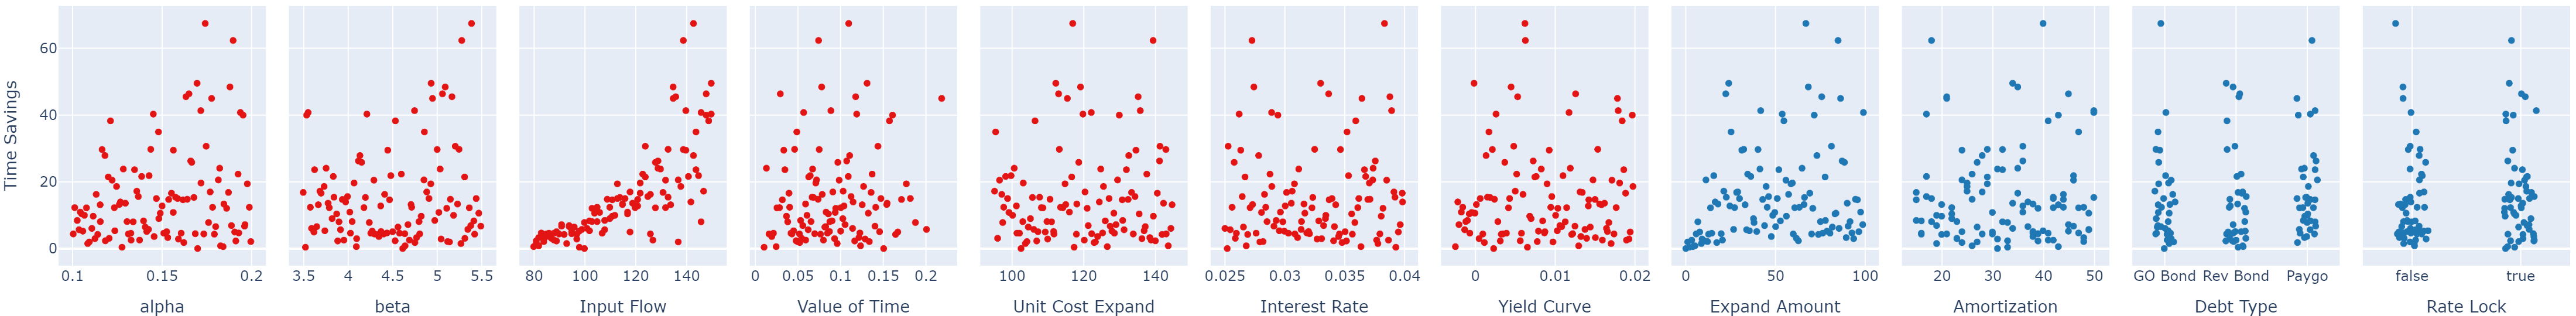

Net Benefits

<xmle.Elem 'img' with 0 children>
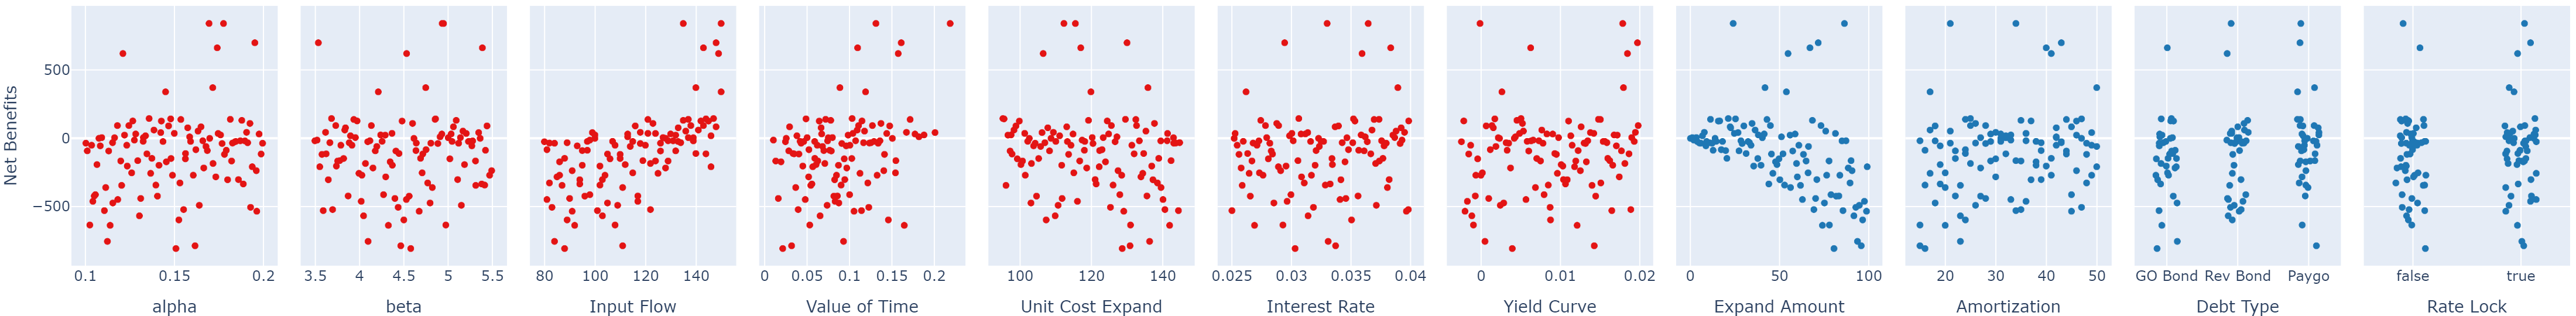

Input Flow

<xmle.Elem 'img' with 0 children>
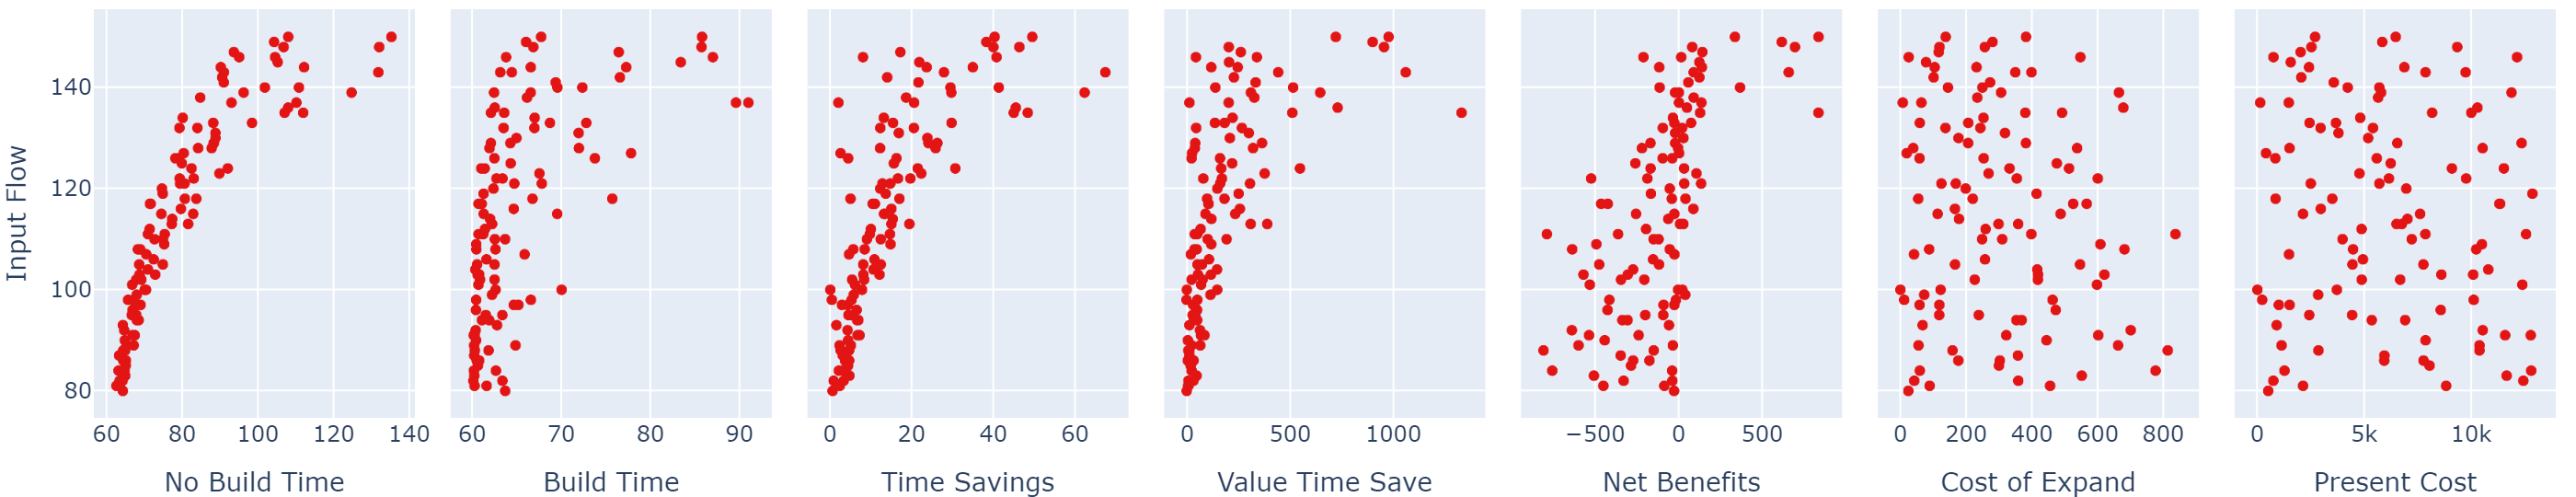

In [27]:
from emat.analysis import display_experiments
display_experiments(road_scope, lhs_results, rows=['time_savings', 'net_benefits', 'input_flow'])

In [28]:
from emat.analysis.prim import Prim
of_interest = lhs_large_results['net_benefits']>0
discovery = Prim(
    m.read_experiment_parameters(design_name='lhs_large'),
    of_interest,
    scope=road_scope,
)

In [29]:
box1 = discovery.find_box()
box1.tradeoff_selector()

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': array([0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
                                         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
                                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=object),
                         'colorbar': {'tickmode': 'array',
                                      'ticks': 'outside',
                                      'ticktext': [0, 1, 2, 3, 4, 5],
                                      'tickvals': array([0.41666667, 1.25      , 2.08333333, 2.91666667, 3.75      , 4.58333333]),
                                      'title': {'side': 'right', 'text': 'Number of Restricted Dimensions'}},
                         'colorscale': [[0.0, 'rgb(70, 49, 126)'],
                                        [0.16666666666666666, 'rgb(70, 49, 126)'],
                                      

In [30]:
box1.inspect(45)

coverage    0.489606
density     0.871173
id                45
mass        0.156800
mean        0.871173
res_dim            5
Name: 45, dtype: object

                         box 45                                            
                            min         max                       qp values
expand_capacity        0.000672   95.018708     [-1.0, 0.06797686844207428]
input_flow           128.000000  150.000000  [4.181142828811809e-168, -1.0]
value_of_time          0.077057    0.236016  [2.2257439851081843e-37, -1.0]
beta                   3.597806    5.499712      [0.1926809470209529, -1.0]
amortization_period   17.000000   50.000000     [0.20016307300821792, -1.0]



In [31]:
box1.select(45)
box1.splom()

FigureWidget({
    'data': [{'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'uid': '2cb42783-216f-43ff-8f6e-2afee2a23aa5',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'fill': 'tozeroy',
              'line': {'color': 'rgb(31, 119, 180)'},
              'showlegend': False,
              'type': 'scatter',
              'uid': 'b4a67324-43ab-4a6a-a1f2-d783e9fb9621',
              'x': array([12.55      , 12.75050251, 12.95100503, 13.15150754, 13.35201005,
                          13.55251256, 13.75301508, 13.95351759, 14.1540201 , 14.35452261,
                          14.55502513, 14.75552764, 14.95603015, 15.15653266, 15.35703518,
                          15.55753769, 15.7580402 , 15.95854271, 16.15904523, 16.35954774,
                          16.56005025, 16.76055276, 16.96105528, 17.16155779, 17.3620603 ,
                          17.56256281, 17.7630653

In [32]:
from emat.workbench.analysis import cart

cart_alg = cart.CART(
    m.read_experiment_parameters(design_name='lhs_large'),
    of_interest,
)
cart_alg.build_tree()

In [33]:
from emat.util.xmle import Show
Show(cart_alg.show_tree(format='svg'))

FileNotFoundError: [WinError 2] "dot" not found in path.

In [34]:
cart_alg.boxes_to_dataframe(include_stats=True)

Box Statistics                                                \
             coverage   density      gini   entropy res dim    mass   
box 0        0.027957  0.150579  0.255810  0.611288       2  0.0518   
box 1        0.015054  0.057065  0.107618  0.315683       2  0.0736   
box 2        0.000000  0.000000  0.000000  0.000000       3  0.2522   
box 3        0.003584  0.011468  0.022673  0.090374       3  0.0872   
box 4        0.085305  0.449057  0.494810  0.992499       2  0.0530   
box 5        0.032975  0.104784  0.187608  0.483978       2  0.0878   
box 6        0.083154  0.442748  0.493444  0.990522       3  0.0524   
box 7        0.025806  0.109091  0.194380  0.497168       3  0.0660   
box 8        0.160573  0.797153  0.323400  0.727586       3  0.0562   
box 9        0.330466  0.954451  0.086948  0.267178       3  0.0966   
box 10       0.075269  0.335463  0.445855  0.920411       3  0.0626   
box 11       0.159857  0.735974  0.388633  0.832762       3  0.0606   

       expand_capacity            input_flow        value_of_time            
                   min        max        min    max           min       max  
box 0              NaN  10.954633        NaN  112.5           NaN       NaN  
box 1        10.954633  26.292320        NaN  112.5           NaN       NaN  
box 2        26.292320        NaN        NaN  112.5           NaN  0.124238  
box 3        26.292320        NaN        NaN  112.5      0.124238       NaN  
box 4              NaN  41.220825      112.5  122.5           NaN       NaN  
box 5        41.220825        NaN      112.5  122.5           NaN       NaN  
box 6              NaN  42.598623      122.5    NaN           NaN  0.061168  
box 7        42.598623        NaN      122.5    NaN           NaN  0.061168  
box 8              NaN  55.393572      122.5    NaN      0.061168  0.096174  
box 9              NaN  55.393572      122.5    NaN      0.096174       NaN  
box 10       55.393572        NaN      122.5  136.5      0.061168       NaN  
box 11       55.393572        NaN      136.5    NaN      0.061168       NaN

In [35]:
from emat import Measure

MAXIMIZE = Measure.MAXIMIZE
MINIMIZE = Measure.MINIMIZE

robustness_functions = [
    Measure(
        'Expected Net Benefit',
        kind=Measure.INFO,
        variable_name='net_benefits',
        function=numpy.mean,
    ),

    Measure(
        'Probability of Net Loss',
        kind=MINIMIZE,
        variable_name='net_benefits',
        function=lambda x: numpy.mean(x<0),
    ),

    Measure(
        '95%ile Travel Time',
        kind=MINIMIZE,
        variable_name='build_travel_time',
        function=functools.partial(numpy.percentile, q=95),
    ),

    Measure(
        '99%ile Present Cost',
        kind=Measure.INFO,
        variable_name='present_cost_expansion',
        function=functools.partial(numpy.percentile, q=99),
    ),

    Measure(
        'Expected Present Cost',
        kind=Measure.INFO,
        variable_name='present_cost_expansion',
        function=numpy.mean,
    ),

]

In [36]:
from emat import Constraint

In [37]:
constraint_1 = Constraint(
    "Maximum Log Expected Present Cost",
    outcome_names="Expected Present Cost",
    function=Constraint.must_be_less_than(4000),
)

In [38]:
constraint_2 = Constraint(
    "Minimum Capacity Expansion",
    parameter_names="expand_capacity",
    function=Constraint.must_be_greater_than(10),
)

In [39]:
constraint_3 = Constraint(
    "Maximum Paygo",
    parameter_names='debt_type',
    outcome_names='99%ile Present Cost',
    function=lambda i,j: max(0, j-1500) if i=='Paygo' else 0,
)

In [40]:
robust_results = m.robust_optimize(
    robustness_functions,
    scenarios=200,
    nfe=2500,
    constraints=[
        constraint_1,
        constraint_2,
        constraint_3,
    ],
    #evaluator=get_client(),
    cache_file="./cache_road_test_robust_opt"
)

ConvergenceMetrics(children=(FigureWidget({
    'data': [{'fill': 'tonexty',
              'line': {'shape': '…

In [41]:
robust_results.par_coords()

ParCoordsViewer(children=(FigureWidget({
    'data': [{'dimensions': [{'label': '(L) Expand Amount',
         …

In [42]:
mm = m.create_metamodel_from_design('lhs', suppress_converge_warnings=True)
mm

<emat.PythonCoreModel "MetaModel1", metamodel_id=1 with 2 constants, 7 uncertainties, 4 levers, 7 measures>

In [43]:
design2 = design_experiments(
    scope=road_scope,
    db=emat_db,
    n_samples_per_factor=10,
    sampler='lhs',
    random_seed=2,
)

In [44]:
design2_results = mm.run_experiments(design2)
design2_results.head()

alpha  amortization_period      beta debt_type  \
experiment                                                      
5111        0.113526                   48  5.344274   GO Bond   
5112        0.112148                   29  4.579477  Rev Bond   
5113        0.119548                   32  4.353462  Rev Bond   
5114        0.102516                   42  4.490051   GO Bond   
5115        0.140831                   17  5.024638  Rev Bond   

            expand_capacity  input_flow  interest_rate  interest_rate_lock  \
experiment                                                                   
5111              75.218326         142       0.033177                True   
5112              24.154443         132       0.034554               False   
5113              84.003562         148       0.032211               False   
5114              51.580600         150       0.028362               False   
5115              74.351908         120       0.033885               False   

            unit_cost_expansion  value_of_time  yield_curve  free_flow_time  \
experiment                                                                    
5111                 131.820315       0.087901     0.000400              60   
5112                 133.709154       0.058116     0.005657              60   
5113                  95.650097       0.040388     0.013589              60   
5114                 136.919028       0.204260    -0.001315              60   
5115                 115.270765       0.067252     0.009138              60   

            initial_capacity  no_build_travel_time  build_travel_time  \
experiment                                                              
5111                     100            104.148954          63.321424   
5112                     100             83.989610          70.084484   
5113                     100            100.157356          64.082454   
5114                     100             98.814377          67.777076   
5115                     100             81.164332          61.855079   

            time_savings  value_of_time_savings  net_benefits  \
experiment                                                      
5111           41.659859             597.571872     25.776227   
5112           14.899891             112.732193   -151.094935   
5113           44.139409             499.171988   -152.588280   
5114           34.088431            1496.242470    378.793375   
5115           19.287028             163.665531   -289.170556   

            cost_of_capacity_expansion  present_cost_expansion  
experiment                                                      
5111                        291.911475            10016.620406  
5112                        175.930363             3185.499652  
5113                        584.739654            10448.392699  
5114                        296.906359             6639.327302  
5115                        722.878920             8767.422650

In [45]:
mm.cross_val_scores()

No Build Time

<xmle.Elem 'img' with 0 children>
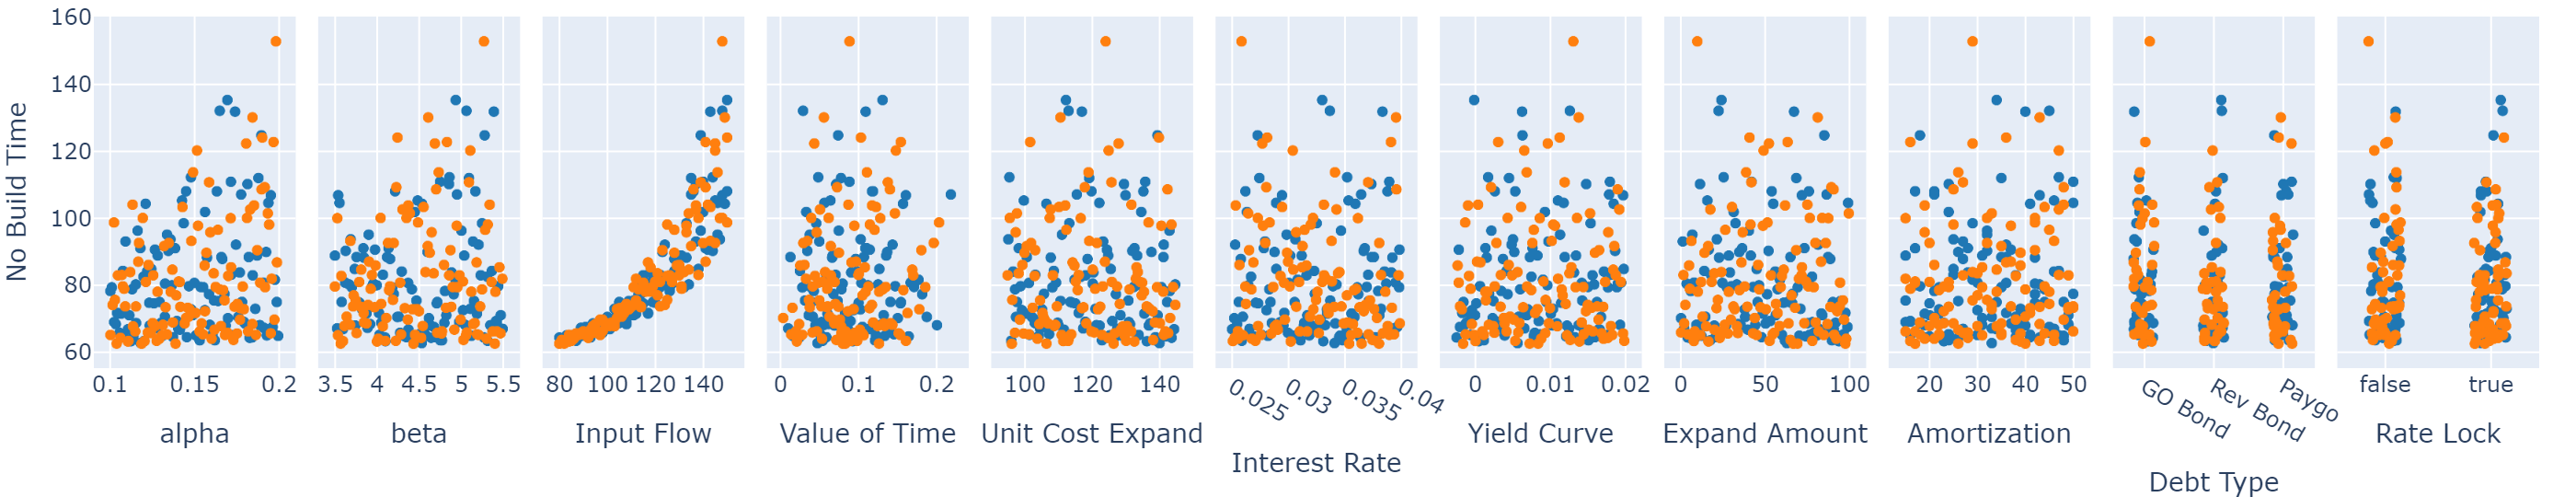

Build Time

<xmle.Elem 'img' with 0 children>
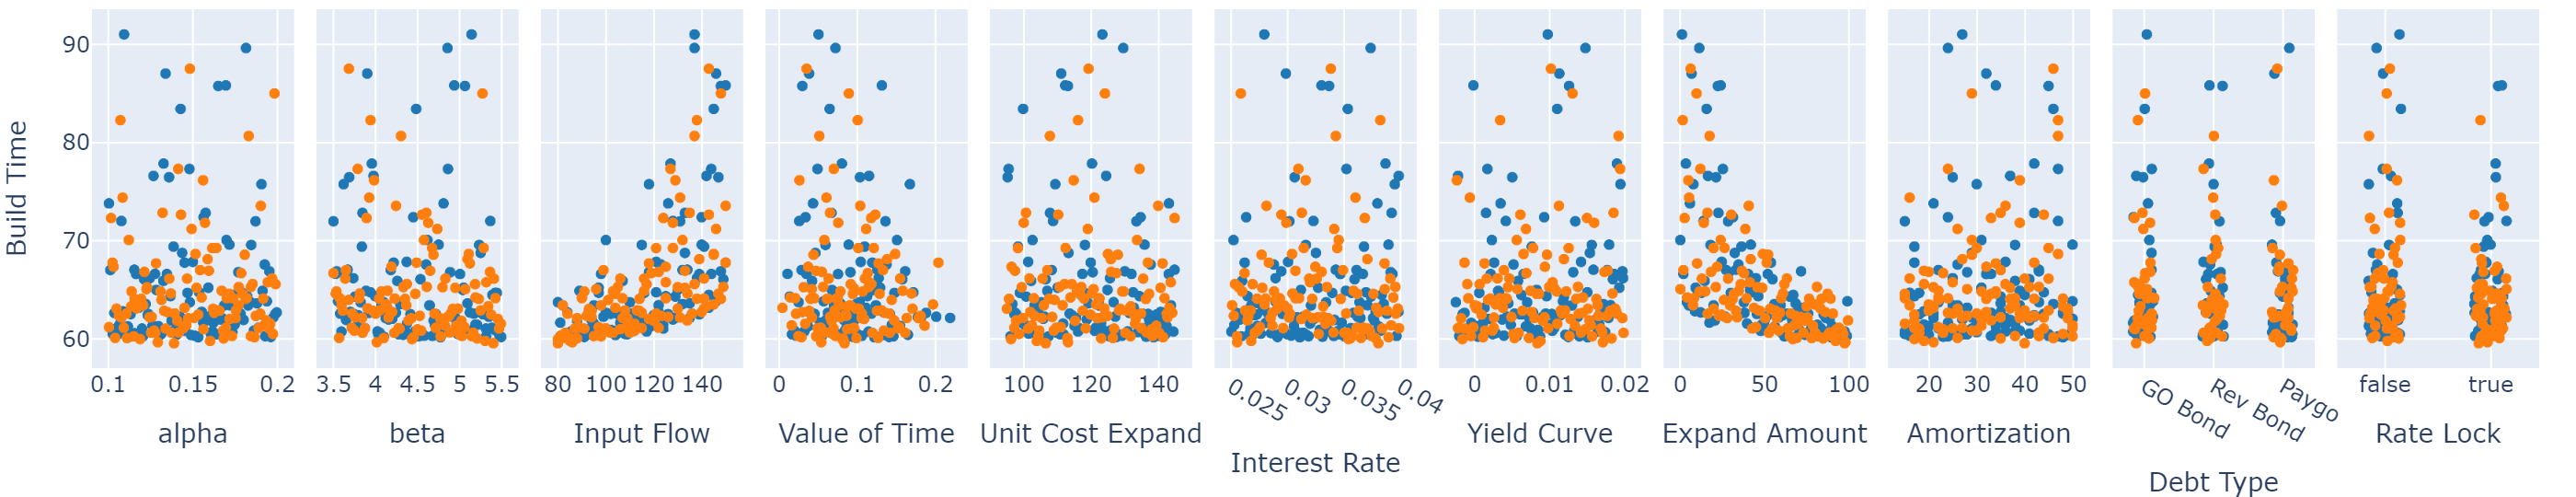

Time Savings

<xmle.Elem 'img' with 0 children>
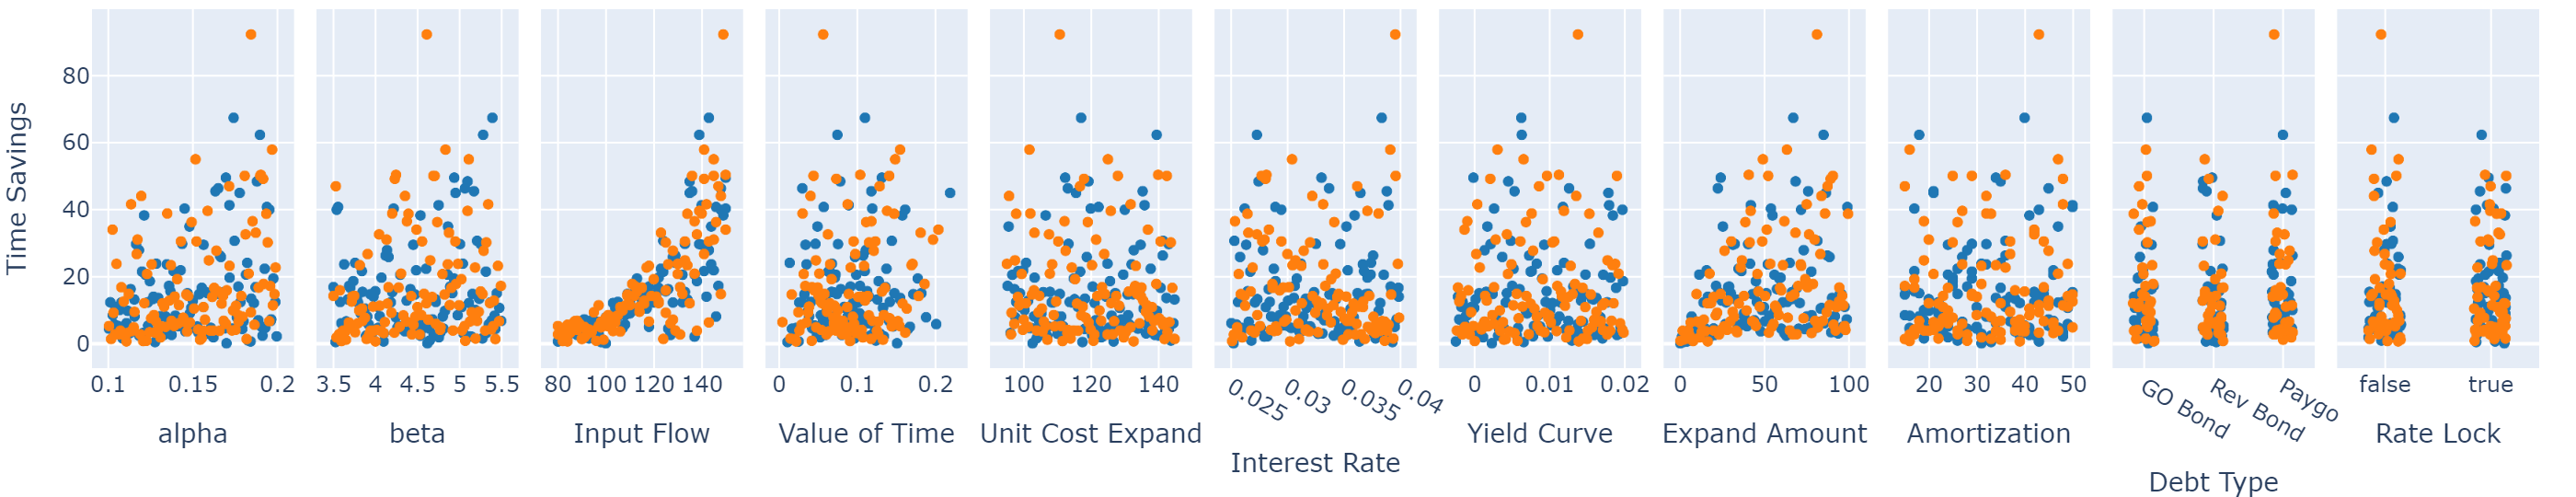

Value Time Save

<xmle.Elem 'img' with 0 children>
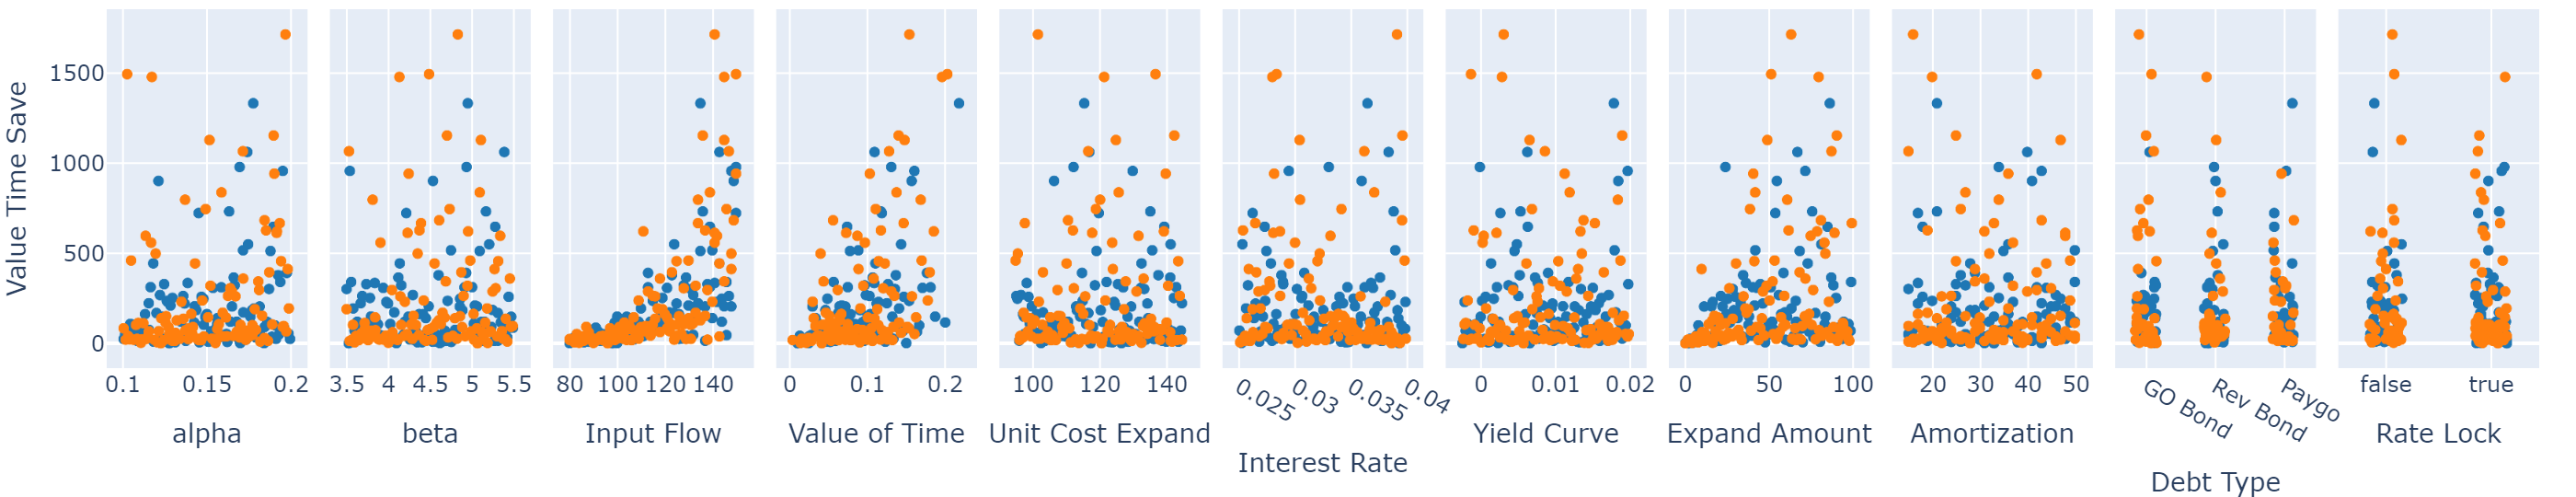

Net Benefits

<xmle.Elem 'img' with 0 children>
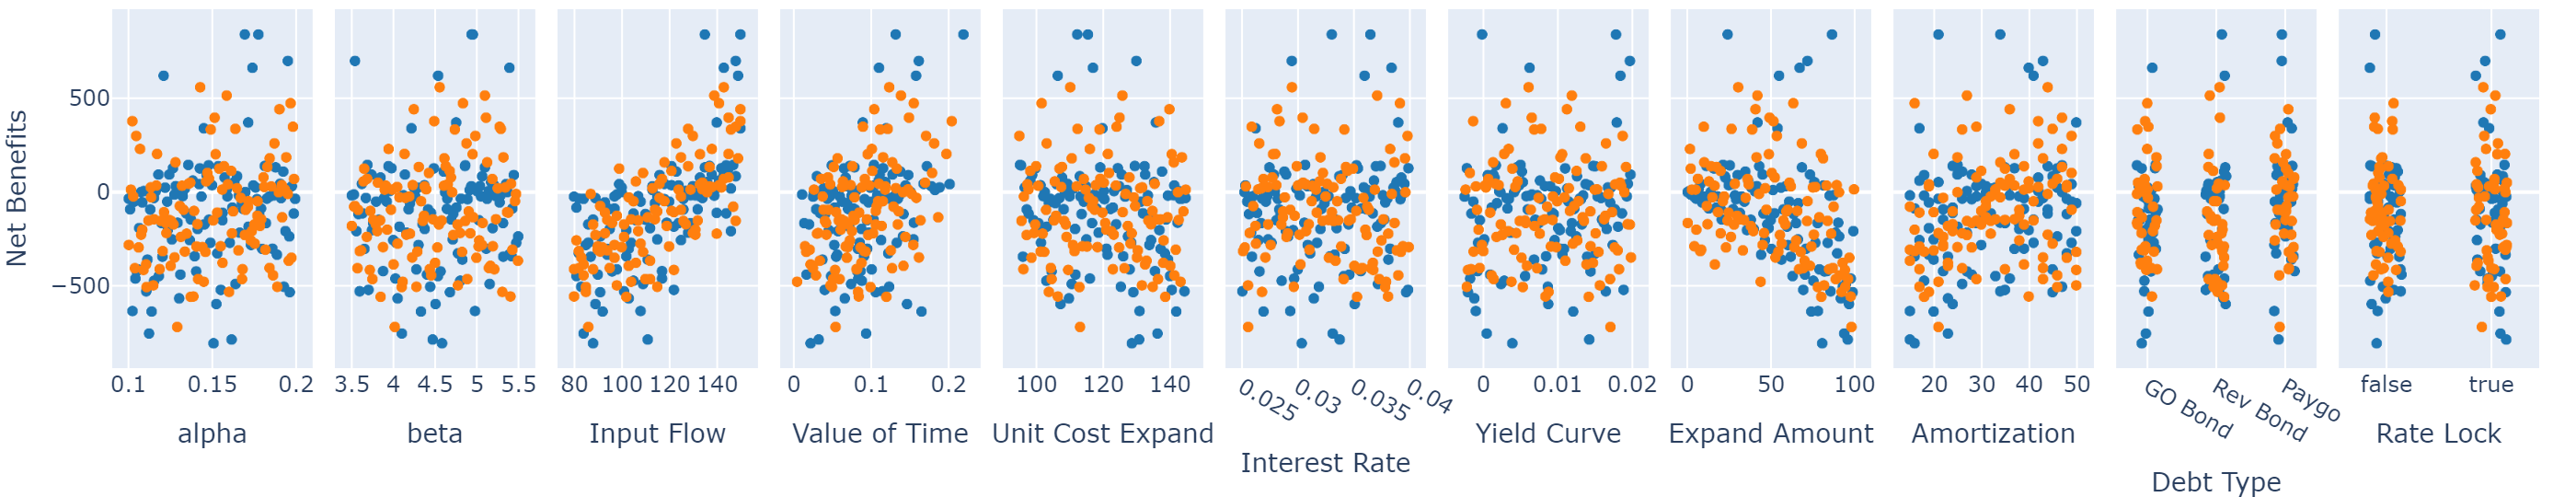

Cost of Expand

<xmle.Elem 'img' with 0 children>
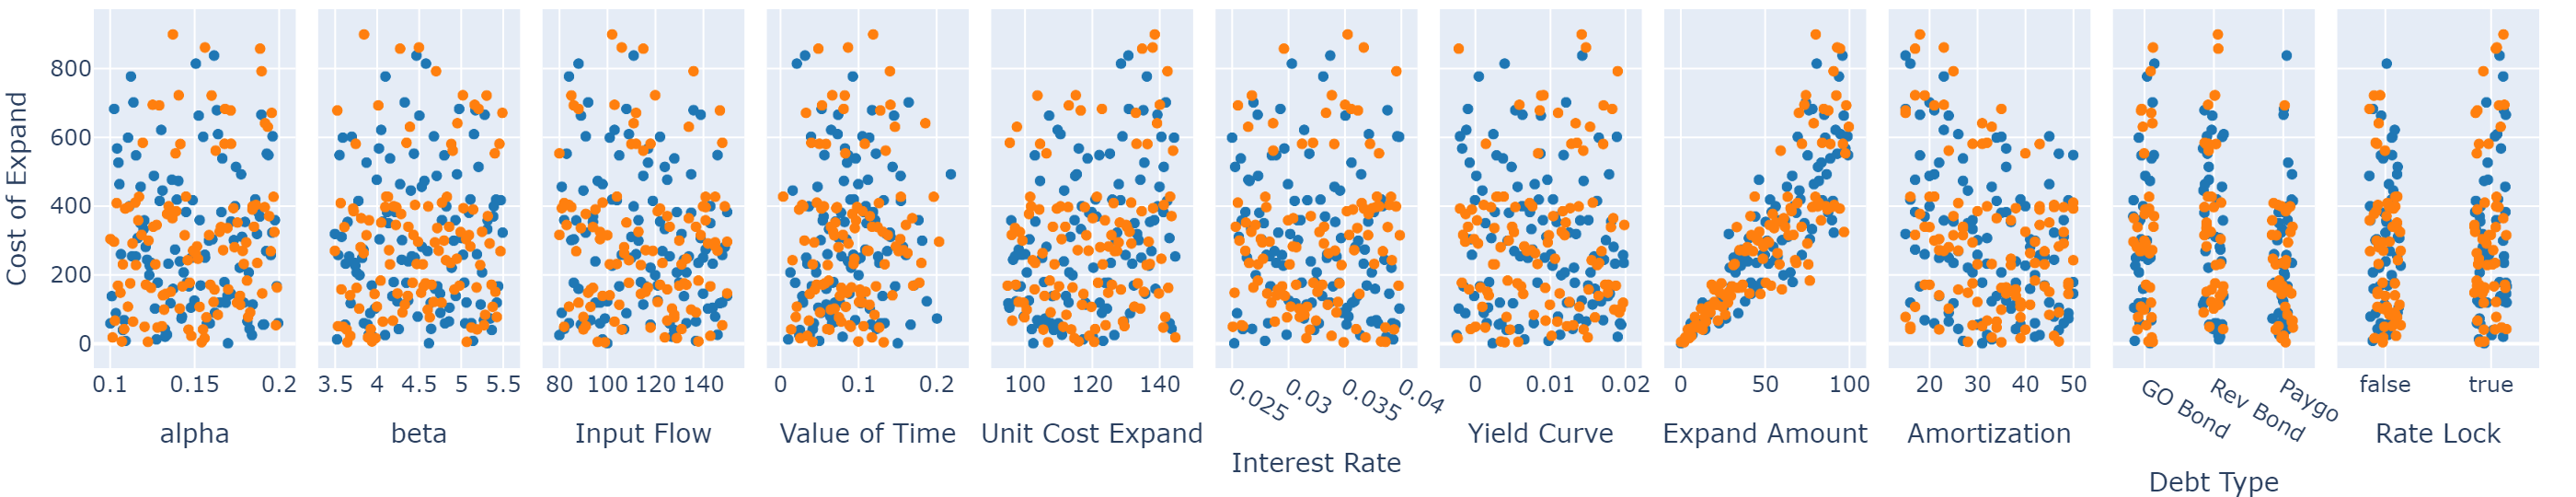

Present Cost

<xmle.Elem 'img' with 0 children>
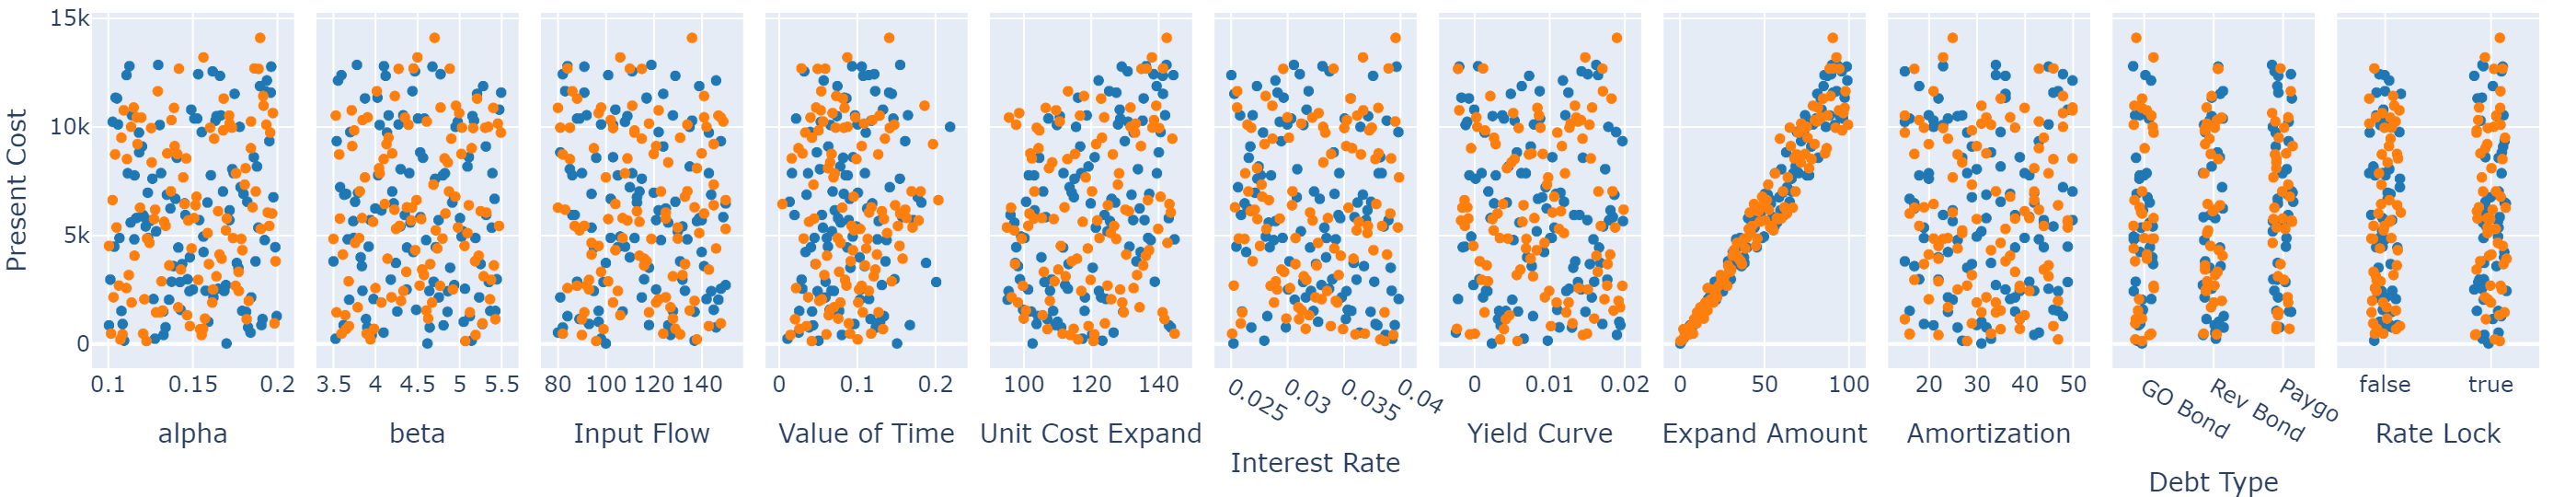

In [46]:
from emat.analysis import contrast_experiments
contrast_experiments(road_scope, lhs_results, design2_results)